In [1]:
!pip install optuna

In [2]:
from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False,gamma=1):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = gamma # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]


In [3]:
import numpy as np
from scipy.special import softmax

def sarsa(model, alpha=0.5, epsilon=0.1, maxiter=100, maxeps=1000, temperature=1.0, action_strategy='epsilon-greedy'):
    """
    Solves the supplied environment using SARSA.

    Parameters
    ----------
    model : python object
        Holds information about the environment to solve
        such as the reward structure and the transition dynamics.

    alpha : float
        Algorithm learning rate. Defaults to 0.5.

    epsilon : float
        Probability that a random action is selected. epsilon must be
        in the interval [0,1] where 0 means that the action is selected
        in a completely greedy manner and 1 means the action is always
        selected randomly.

    maxiter : int
        The maximum number of iterations to perform per episode.
        Defaults to 100.

    maxeps : int
        The number of episodes to run SARSA for.
        Defaults to 1000.

    temperature : float, optional
        Controls the level of exploration. Higher temperature leads to more
        exploration, while lower temperature makes the action selection more
        deterministic. Defaults to 1.0.

    action_strategy : str, optional
        Action selection strategy: 'epsilon-greedy' or 'softmax'.
        Defaults to 'epsilon-greedy'.

    Returns
    -------
    q : numpy array of shape (N, 1)
        The state-action value for the environment where N is the
        total number of states.

    pi : numpy array of shape (N, 1)
        Optimal policy for the environment where N is the total
        number of states.

    state_counts : numpy array of shape (N, 1)
        Counts of the number of times each state is visited.

    total_steps_per_episode : list
        List containing the total steps per episode.

    total_rewards_per_episode : list
        List containing the total rewards per episode.
    """
    # initialize the state-action value function and the state counts
    Q = np.zeros((model.num_states, model.num_actions))
    state_counts = np.zeros((model.num_states, 1))
    
    total_steps_per_episode = []
    total_rewards_per_episode = []

    for i in range(maxeps):

        if np.mod(i, 1000) == 0:
            print("Running episode %i." % i)

        # for each new episode, start at the given start state
        state = int(model.start_state_seq)
        # sample first action
        action = sample_action(Q, state, model.num_actions, epsilon, temperature, action_strategy)
        episode_steps = 0
        episode_rewards = 0

        for j in range(maxiter):
            # initialize p and r
            p, r = 0, np.random.random()
            # sample the next state according to the action and the
            # probability of the transition
            for next_state in range(model.num_states):
                p += model.P[state, next_state, action]
                if r <= p:
                    break
            # sample the next action
            next_action = sample_action(Q, next_state, model.num_actions, epsilon, temperature, action_strategy)
            # Calculate the temporal difference and update Q function
            Q[state, action] += alpha * (model.R[state] + model.gamma * Q[next_state, next_action] - Q[state, action])
            # End episode is state is a terminal state
            episode_steps += 1
            episode_rewards += model.R[state]

            if np.any(state == model.goal_states_seq):
                break

            # count the state visits
            state_counts[state] += 1

            # store the previous state and action
            state = next_state
            action = next_action

        total_steps_per_episode.append(int(episode_steps))
        total_rewards_per_episode.append(int(episode_rewards))

    # determine the q function and policy
    q = np.max(Q, axis=1).reshape(-1, 1)
    pi = np.argmax(Q, axis=1).reshape(-1, 1)

    return q, pi, state_counts, total_steps_per_episode, total_rewards_per_episode

def sample_action(Q, state, num_actions, epsilon, temperature=1.0, action_strategy='epsilon-greedy'):
    """
    Action selection based on the specified strategy.

    Parameters
    ----------
    Q : numpy array of shape (N, num_actions)
        Q function for the environment where N is the total number of states.

    state : int
        The current state.

    num_actions : int
        The number of actions.

    epsilon : float
        Probability that a random action is selected. epsilon must be
        in the interval [0,1] where 0 means that the action is selected
        in a completely greedy manner and 1 means the action is always
        selected randomly.

    temperature : float, optional
        Controls the level of exploration. Higher temperature leads to more
        exploration, while lower temperature makes the action selection more
        deterministic. Defaults to 1.0.

    action_strategy : str, optional
        Action selection strategy: 'epsilon-greedy' or 'softmax'.
        Defaults to 'epsilon-greedy'.

    Returns
    -------
    action : int
        Number representing the selected action between 0 and num_actions.
    """
    if action_strategy == 'epsilon-greedy':
        if np.random.random() < epsilon:
            action = np.random.randint(0, num_actions)
        else:
            action = np.argmax(Q[state, :])
    elif action_strategy == 'softmax':
        action_values = Q[state, :]
        probabilities = softmax(action_values / temperature)
        action = np.random.choice(np.arange(num_actions), p=probabilities)
    else:
        raise ValueError("Invalid action_strategy. Use 'epsilon-greedy' or 'softmax'.")

    return action


def qlearning(model, alpha=0.5, epsilon=0.1, maxiter=100, maxeps=1000, temperature=1.0, action_strategy='epsilon-greedy'):
    """
    Solves the supplied environment using Q-learning.

    Parameters
    ----------
    model : python object
        Holds information about the environment to solve
        such as the reward structure and the transition dynamics.

    alpha : float
        Algorithm learning rate. Defaults to 0.5.

    epsilon : float
        Probability that a random action is selected. epsilon must be
        in the interval [0,1] where 0 means that the action is selected
        in a completely greedy manner and 1 means the action is always
        selected randomly.

    maxiter : int
        The maximum number of iterations to perform per episode.
        Defaults to 100.

    maxeps : int
        The number of episodes to run Q-learning for.
        Defaults to 1000.

    temperature : float, optional
        Controls the level of exploration. Higher temperature leads to more
        exploration, while lower temperature makes the action selection more
        deterministic. Defaults to 1.0.

    action_strategy : str, optional
        Action selection strategy: 'epsilon-greedy' or 'softmax'.
        Defaults to 'epsilon-greedy'.

    Returns
    -------
    q : numpy array of shape (N, 1)
        The state-action value for the environment where N is the
        total number of states.

    pi : numpy array of shape (N, 1)
        Optimal policy for the environment where N is the total
        number of states.

    state_counts : numpy array of shape (N, 1)
        Counts of the number of times each state is visited.

    total_steps_per_episode : list
        List containing the total steps per episode.

    total_rewards_per_episode : list
        List containing the total rewards per episode.
    """
    Q = np.zeros((model.num_states, model.num_actions))
    state_counts = np.zeros((model.num_states, 1))

    total_steps_per_episode = []
    total_rewards_per_episode = []

    for i in range(maxeps):
        if np.mod(i, 1000) == 0:
            print("Running episode %i." % i)

        state = int(model.start_state_seq)
        episode_steps = 0
        episode_rewards = 0

        for j in range(maxiter):
            action = sample_action(Q, state, model.num_actions, epsilon, temperature, action_strategy)

            p, r = 0, np.random.random()

            for next_state in range(model.num_states):
                p += model.P[state, next_state, action]
                if r <= p:
                    break

            Q[state, action] += alpha * (model.R[state] + model.gamma * np.max(Q[next_state, :]) - Q[state, action])

            state_counts[state] += 1

            state = next_state
            episode_steps += 1
            episode_rewards += model.R[state]

            if np.any(state == model.goal_states_seq):
                break

        total_steps_per_episode.append(int(episode_steps))
        total_rewards_per_episode.append(int(episode_rewards))

    q = np.max(Q, axis=1).reshape(-1, 1)
    pi = np.argmax(Q, axis=1).reshape(-1, 1)

    return q, pi, state_counts, total_steps_per_episode, total_rewards_per_episode

In [4]:
from plots import plot_gridworld

In [5]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                              bias=0.5)

env_0 = gw.create_gridworld()


In [6]:
import optuna

In [7]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    epsilon = trial.suggest_float('epsilon', 0.1, 0.5, log=True)
    g=trial.suggest_float('gamma',0.8,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Epsilon = {epsilon},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=g)
    gw.add_obstructions(obstructed_states=obstructions,
                            bad_states=bad_states,
                            restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                    goal_reward=10,
                    bad_state_reward=-6,
                    restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=1,
                                    bias=0.5)

    env_0 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts, steps, rewards = qlearning(env_0, alpha=alpha, epsilon=epsilon, maxiter=100, maxeps=5000)
        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials

# Get the best hyperparameters


[I 2024-02-27 14:46:24,572] A new study created in memory with name: no-name-71821a50-8e88-41cf-b397-431b61c5e9aa


Trial 0: Alpha = 0.11054461438723859, Epsilon = 0.23495332246800932,Gamma=0.8615702647307766
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:46:40,648] Trial 0 finished with value: 100794.4 and parameters: {'alpha': 0.11054461438723859, 'epsilon': 0.23495332246800932, 'gamma': 0.8615702647307766}. Best is trial 0 with value: 100794.4.


Trial 1: Alpha = 0.21075961992953926, Epsilon = 0.28833733272797996,Gamma=0.8102662957547259
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:46:57,141] Trial 1 finished with value: 107663.4 and parameters: {'alpha': 0.21075961992953926, 'epsilon': 0.28833733272797996, 'gamma': 0.8102662957547259}. Best is trial 0 with value: 100794.4.


Trial 2: Alpha = 0.12320389819331498, Epsilon = 0.16222437620299057,Gamma=0.8099558426290966
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:47:12,493] Trial 2 finished with value: 79088.0 and parameters: {'alpha': 0.12320389819331498, 'epsilon': 0.16222437620299057, 'gamma': 0.8099558426290966}. Best is trial 2 with value: 79088.0.


Trial 3: Alpha = 0.41145160767972183, Epsilon = 0.16244205164849804,Gamma=0.9887032230351845
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:47:26,579] Trial 3 finished with value: 66401.3 and parameters: {'alpha': 0.41145160767972183, 'epsilon': 0.16244205164849804, 'gamma': 0.9887032230351845}. Best is trial 3 with value: 66401.3.


Trial 4: Alpha = 0.17462306146940856, Epsilon = 0.2672929352502644,Gamma=0.9131568881583285
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:47:43,355] Trial 4 finished with value: 102592.1 and parameters: {'alpha': 0.17462306146940856, 'epsilon': 0.2672929352502644, 'gamma': 0.9131568881583285}. Best is trial 3 with value: 66401.3.


Trial 5: Alpha = 0.38789658892733536, Epsilon = 0.4885085250579008,Gamma=0.9468763607164327
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:48:07,192] Trial 5 finished with value: 209592.3 and parameters: {'alpha': 0.38789658892733536, 'epsilon': 0.4885085250579008, 'gamma': 0.9468763607164327}. Best is trial 3 with value: 66401.3.


Trial 6: Alpha = 0.29601437869691233, Epsilon = 0.10472846477895414,Gamma=0.9469713189493096
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:48:20,548] Trial 6 finished with value: 56214.8 and parameters: {'alpha': 0.29601437869691233, 'epsilon': 0.10472846477895414, 'gamma': 0.9469713189493096}. Best is trial 6 with value: 56214.8.


Trial 7: Alpha = 0.12444184468172925, Epsilon = 0.13684175840207047,Gamma=0.9990266353805752
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:48:35,261] Trial 7 finished with value: 71364.0 and parameters: {'alpha': 0.12444184468172925, 'epsilon': 0.13684175840207047, 'gamma': 0.9990266353805752}. Best is trial 6 with value: 56214.8.


Trial 8: Alpha = 0.15728368206517485, Epsilon = 0.3273168218327035,Gamma=0.898988856440359
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:48:53,875] Trial 8 finished with value: 125430.5 and parameters: {'alpha': 0.15728368206517485, 'epsilon': 0.3273168218327035, 'gamma': 0.898988856440359}. Best is trial 6 with value: 56214.8.


Trial 9: Alpha = 0.44128339237496655, Epsilon = 0.1544220924244136,Gamma=0.9477514921569585
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 14:49:07,853] Trial 9 finished with value: 64666.600000000006 and parameters: {'alpha': 0.44128339237496655, 'epsilon': 0.1544220924244136, 'gamma': 0.9477514921569585}. Best is trial 6 with value: 56214.8.


Running episode 4000.
Trial 10: Alpha = 0.2896784890044001, Epsilon = 0.10237222621743415,Gamma=0.8690781243837425
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:49:21,231] Trial 10 finished with value: 56440.899999999994 and parameters: {'alpha': 0.2896784890044001, 'epsilon': 0.10237222621743415, 'gamma': 0.8690781243837425}. Best is trial 6 with value: 56214.8.


Trial 11: Alpha = 0.2848952588804891, Epsilon = 0.10029877621998684,Gamma=0.8523384845501193
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:49:34,475] Trial 11 finished with value: 56303.0 and parameters: {'alpha': 0.2848952588804891, 'epsilon': 0.10029877621998684, 'gamma': 0.8523384845501193}. Best is trial 6 with value: 56214.8.


Trial 12: Alpha = 0.27605816286418244, Epsilon = 0.10403601110475341,Gamma=0.8509068868398789
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:49:48,061] Trial 12 finished with value: 57238.3 and parameters: {'alpha': 0.27605816286418244, 'epsilon': 0.10403601110475341, 'gamma': 0.8509068868398789}. Best is trial 6 with value: 56214.8.


Trial 13: Alpha = 0.2865764880386412, Epsilon = 0.1251130762889107,Gamma=0.9366687166279167
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:50:01,581] Trial 13 finished with value: 61137.7 and parameters: {'alpha': 0.2865764880386412, 'epsilon': 0.1251130762889107, 'gamma': 0.9366687166279167}. Best is trial 6 with value: 56214.8.


Trial 14: Alpha = 0.3275809456517419, Epsilon = 0.19066265605921748,Gamma=0.8392324102019662
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:50:16,403] Trial 14 finished with value: 75292.8 and parameters: {'alpha': 0.3275809456517419, 'epsilon': 0.19066265605921748, 'gamma': 0.8392324102019662}. Best is trial 6 with value: 56214.8.


Trial 15: Alpha = 0.228109268726465, Epsilon = 0.12117307707773195,Gamma=0.8816604512729508
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:50:30,144] Trial 15 finished with value: 61632.0 and parameters: {'alpha': 0.228109268726465, 'epsilon': 0.12117307707773195, 'gamma': 0.8816604512729508}. Best is trial 6 with value: 56214.8.


Trial 16: Alpha = 0.22793357712680432, Epsilon = 0.20186775444347216,Gamma=0.9150326719068159
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 14:50:45,271] Trial 16 finished with value: 79814.0 and parameters: {'alpha': 0.22793357712680432, 'epsilon': 0.20186775444347216, 'gamma': 0.9150326719068159}. Best is trial 6 with value: 56214.8.


Running episode 4000.
Trial 17: Alpha = 0.37041099915804254, Epsilon = 0.10692300532671702,Gamma=0.8371156938760315
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:50:58,398] Trial 17 finished with value: 55178.9 and parameters: {'alpha': 0.37041099915804254, 'epsilon': 0.10692300532671702, 'gamma': 0.8371156938760315}. Best is trial 17 with value: 55178.9.


Trial 18: Alpha = 0.49512320862742437, Epsilon = 0.38555370740656125,Gamma=0.9673996403751394
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:51:17,640] Trial 18 finished with value: 141326.2 and parameters: {'alpha': 0.49512320862742437, 'epsilon': 0.38555370740656125, 'gamma': 0.9673996403751394}. Best is trial 17 with value: 55178.9.


Trial 19: Alpha = 0.35116358145023263, Epsilon = 0.12460273751099596,Gamma=0.8283103199576528
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:51:30,927] Trial 19 finished with value: 59466.0 and parameters: {'alpha': 0.35116358145023263, 'epsilon': 0.12460273751099596, 'gamma': 0.8283103199576528}. Best is trial 17 with value: 55178.9.


In [8]:

best_alpha = study.best_params['alpha']
best_epsilon = study.best_params['epsilon']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best Epsilon:", best_epsilon)
print("Best gamma:", best_gamma)



Best Hyperparameters:
Best Alpha: 0.37041099915804254
Best Epsilon: 0.10692300532671702
Best gamma: 0.8371156938760315


In [9]:
num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                                bias=0.5)

env_0 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = qlearning(env_0, alpha=best_alpha, epsilon=best_epsilon, maxiter=100, maxeps=5000)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)

Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [10]:
avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


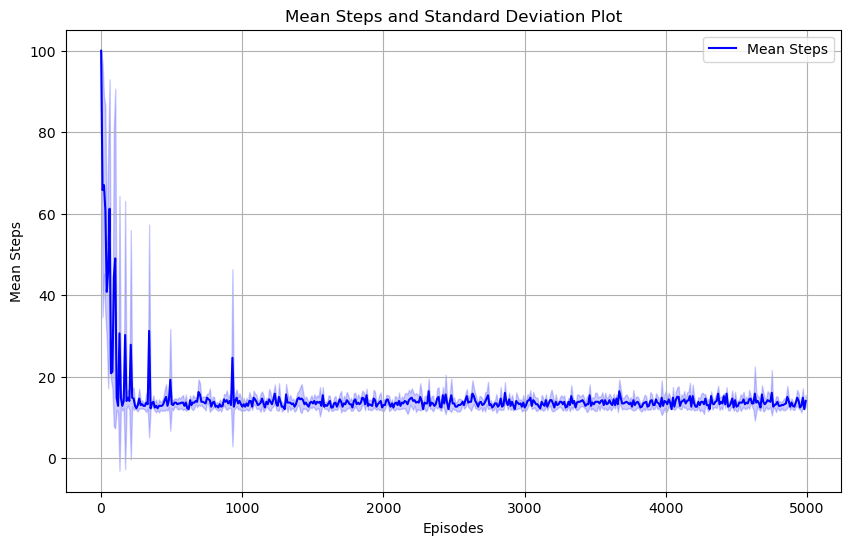

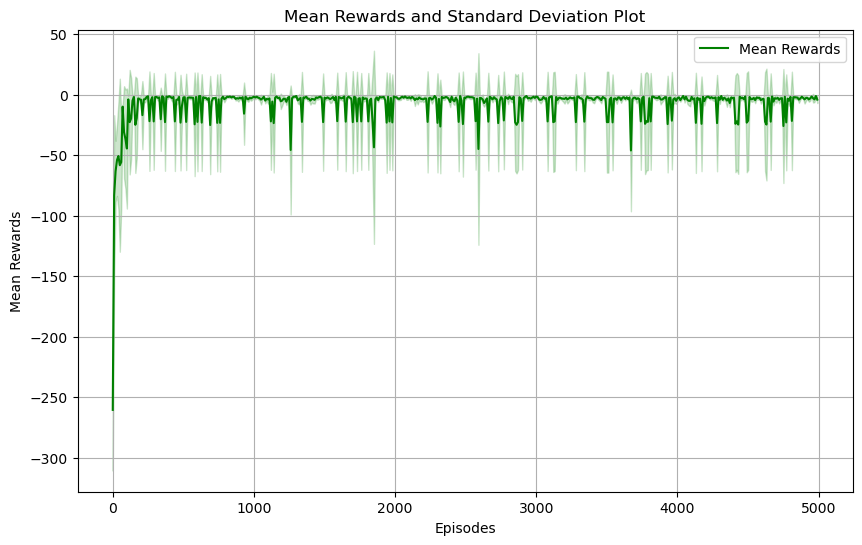

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


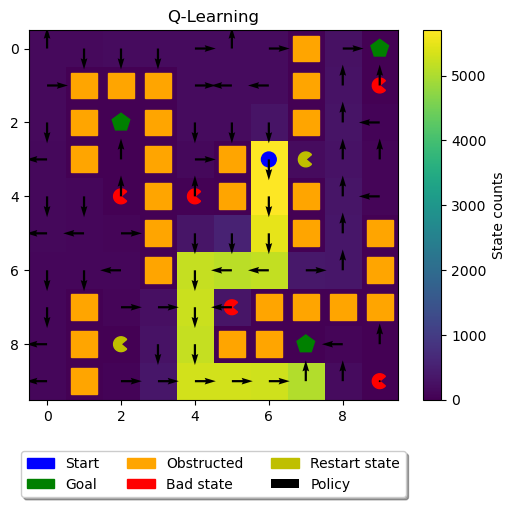

In [12]:
plot_gridworld(env_0, policy=pi, state_counts=avg_state, title="Q-Learning")

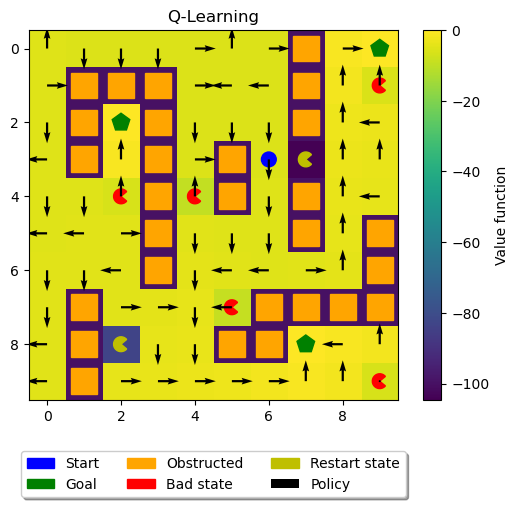

In [13]:

plot_gridworld(env_0, policy=pi,value_function=avg_q, title="Q-Learning")

In [14]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    temp = trial.suggest_float('temperature',0.1,1, log=True)
    g=trial.suggest_float('gamma',0.8,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Temperature = {temp},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=g)
    gw.add_obstructions(obstructed_states=obstructions,
                            bad_states=bad_states,
                            restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                    goal_reward=10,
                    bad_state_reward=-6,
                    restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=1,
                                    bias=0.5)

    env_0 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts,steps,rewards = qlearning(env_0, alpha=alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=temp)

        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials

# Get the best hyperparameters


[I 2024-02-27 14:51:44,762] A new study created in memory with name: no-name-f9e9b75f-b783-4f16-8c30-bd2e8a496aa5


Trial 0: Alpha = 0.26745580142331904, Temperature = 0.31365485946224103,Gamma=0.8513988415313163
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:52:28,211] Trial 0 finished with value: 118756.0 and parameters: {'alpha': 0.26745580142331904, 'temperature': 0.31365485946224103, 'gamma': 0.8513988415313163}. Best is trial 0 with value: 118756.0.


Trial 1: Alpha = 0.287650491143786, Temperature = 0.1291959434124654,Gamma=0.9660499669334572
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:52:49,643] Trial 1 finished with value: 40480.4 and parameters: {'alpha': 0.287650491143786, 'temperature': 0.1291959434124654, 'gamma': 0.9660499669334572}. Best is trial 1 with value: 40480.4.


Trial 2: Alpha = 0.10030696175908262, Temperature = 0.5427530361971746,Gamma=0.9980074436742771
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:53:20,089] Trial 2 finished with value: 73125.4 and parameters: {'alpha': 0.10030696175908262, 'temperature': 0.5427530361971746, 'gamma': 0.9980074436742771}. Best is trial 1 with value: 40480.4.


Trial 3: Alpha = 0.21190106226330102, Temperature = 0.49843066684486526,Gamma=0.8615116143581861
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:54:19,248] Trial 3 finished with value: 175509.09999999998 and parameters: {'alpha': 0.21190106226330102, 'temperature': 0.49843066684486526, 'gamma': 0.8615116143581861}. Best is trial 1 with value: 40480.4.


Trial 4: Alpha = 0.32678109332481126, Temperature = 0.14987767600937285,Gamma=0.831049418916066
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:54:49,489] Trial 4 finished with value: 70316.2 and parameters: {'alpha': 0.32678109332481126, 'temperature': 0.14987767600937285, 'gamma': 0.831049418916066}. Best is trial 1 with value: 40480.4.


Trial 5: Alpha = 0.1125090105581327, Temperature = 0.3008780908852296,Gamma=0.8190495055094563
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:55:49,310] Trial 5 finished with value: 181573.0 and parameters: {'alpha': 0.1125090105581327, 'temperature': 0.3008780908852296, 'gamma': 0.8190495055094563}. Best is trial 1 with value: 40480.4.


Trial 6: Alpha = 0.13391236549657787, Temperature = 0.4765780364022507,Gamma=0.9894724221775608
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:56:17,432] Trial 6 finished with value: 64341.1 and parameters: {'alpha': 0.13391236549657787, 'temperature': 0.4765780364022507, 'gamma': 0.9894724221775608}. Best is trial 1 with value: 40480.4.


Trial 7: Alpha = 0.10687913978155889, Temperature = 0.2917954482672593,Gamma=0.9394964374246226
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:56:45,545] Trial 7 finished with value: 65336.299999999996 and parameters: {'alpha': 0.10687913978155889, 'temperature': 0.2917954482672593, 'gamma': 0.9394964374246226}. Best is trial 1 with value: 40480.4.


Trial 8: Alpha = 0.11697444340673643, Temperature = 0.568654875563994,Gamma=0.8928031192173052
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:57:37,632] Trial 8 finished with value: 148471.9 and parameters: {'alpha': 0.11697444340673643, 'temperature': 0.568654875563994, 'gamma': 0.8928031192173052}. Best is trial 1 with value: 40480.4.


Trial 9: Alpha = 0.2863748490016326, Temperature = 0.30739755051186646,Gamma=0.8502179809327912
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:58:20,712] Trial 9 finished with value: 117109.8 and parameters: {'alpha': 0.2863748490016326, 'temperature': 0.30739755051186646, 'gamma': 0.8502179809327912}. Best is trial 1 with value: 40480.4.


Trial 10: Alpha = 0.485866841434899, Temperature = 0.10032420977166931,Gamma=0.9430121804291889
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:58:41,522] Trial 10 finished with value: 37645.9 and parameters: {'alpha': 0.485866841434899, 'temperature': 0.10032420977166931, 'gamma': 0.9430121804291889}. Best is trial 10 with value: 37645.9.


Trial 11: Alpha = 0.47555170042213757, Temperature = 0.10177410598507,Gamma=0.9438037331759864
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:59:02,446] Trial 11 finished with value: 37711.6 and parameters: {'alpha': 0.47555170042213757, 'temperature': 0.10177410598507, 'gamma': 0.9438037331759864}. Best is trial 10 with value: 37645.9.


Trial 12: Alpha = 0.47315433239867555, Temperature = 0.10370102934856595,Gamma=0.9307708620531319
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:59:23,254] Trial 12 finished with value: 38021.8 and parameters: {'alpha': 0.47315433239867555, 'temperature': 0.10370102934856595, 'gamma': 0.9307708620531319}. Best is trial 10 with value: 37645.9.


Trial 13: Alpha = 0.48809215903910397, Temperature = 0.1798980193018906,Gamma=0.915219585623115
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:59:45,536] Trial 13 finished with value: 42624.7 and parameters: {'alpha': 0.48809215903910397, 'temperature': 0.1798980193018906, 'gamma': 0.915219585623115}. Best is trial 10 with value: 37645.9.


Trial 14: Alpha = 0.39283623420496283, Temperature = 0.9373247140056402,Gamma=0.9549932929497764
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:00:32,675] Trial 14 finished with value: 124260.40000000001 and parameters: {'alpha': 0.39283623420496283, 'temperature': 0.9373247140056402, 'gamma': 0.9549932929497764}. Best is trial 10 with value: 37645.9.


Trial 15: Alpha = 0.16950131596587184, Temperature = 0.20236000317169925,Gamma=0.8951676076211161
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:00:59,065] Trial 15 finished with value: 58462.600000000006 and parameters: {'alpha': 0.16950131596587184, 'temperature': 0.20236000317169925, 'gamma': 0.8951676076211161}. Best is trial 10 with value: 37645.9.


Trial 16: Alpha = 0.37073734378260426, Temperature = 0.1007510493986005,Gamma=0.9670516891441162
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:01:20,228] Trial 16 finished with value: 38542.6 and parameters: {'alpha': 0.37073734378260426, 'temperature': 0.1007510493986005, 'gamma': 0.9670516891441162}. Best is trial 10 with value: 37645.9.


Trial 17: Alpha = 0.4157139316180801, Temperature = 0.21613956035499338,Gamma=0.9035063418218003
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:01:44,522] Trial 17 finished with value: 49363.4 and parameters: {'alpha': 0.4157139316180801, 'temperature': 0.21613956035499338, 'gamma': 0.9035063418218003}. Best is trial 10 with value: 37645.9.


Trial 18: Alpha = 0.21455050924846922, Temperature = 0.1305092235703072,Gamma=0.9370030098351052
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:02:06,926] Trial 18 finished with value: 44031.7 and parameters: {'alpha': 0.21455050924846922, 'temperature': 0.1305092235703072, 'gamma': 0.9370030098351052}. Best is trial 10 with value: 37645.9.


Trial 19: Alpha = 0.33961300090172275, Temperature = 0.1539136677026527,Gamma=0.8737449759100954
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:02:31,575] Trial 19 finished with value: 50010.9 and parameters: {'alpha': 0.33961300090172275, 'temperature': 0.1539136677026527, 'gamma': 0.8737449759100954}. Best is trial 10 with value: 37645.9.


In [15]:

best_alpha = study.best_params['alpha']
best_temp = study.best_params['temperature']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best temp:", best_temp)
print("Best gamma:", best_gamma)



Best Hyperparameters:
Best Alpha: 0.485866841434899
Best temp: 0.10032420977166931
Best gamma: 0.9430121804291889


In [16]:
num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                                bias=0.5)

env_0 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = qlearning(env_0, alpha=best_alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=best_temp)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)

Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [17]:
avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


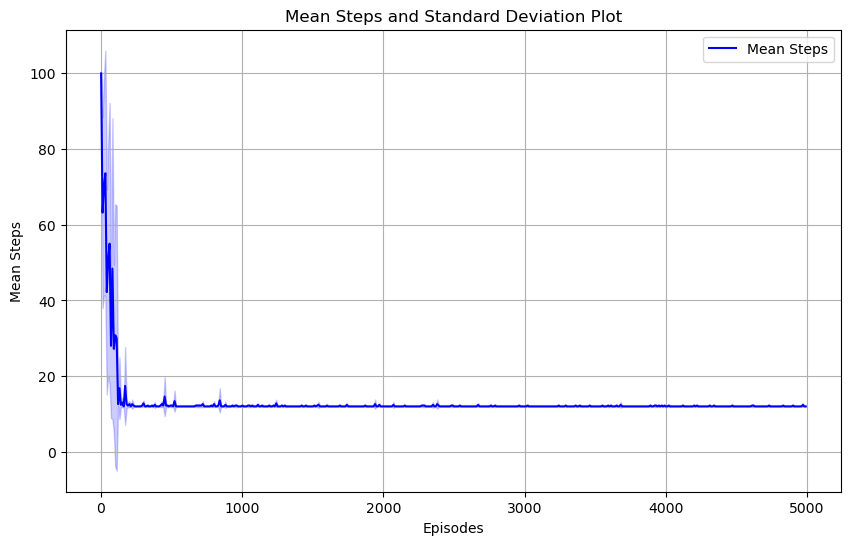

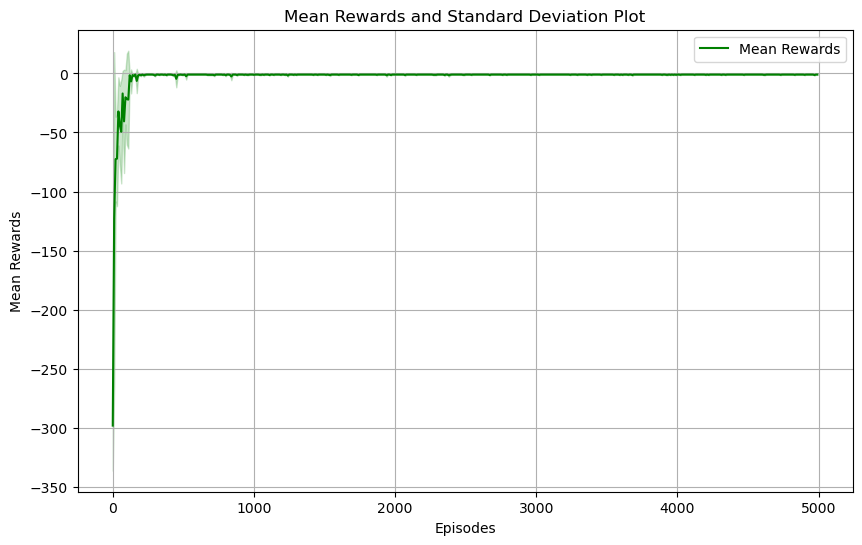

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


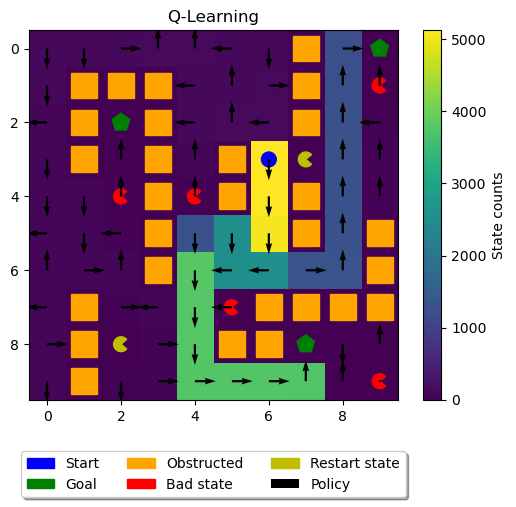

In [19]:

plot_gridworld(env_0, policy=pi, state_counts=avg_state, title="Q-Learning")

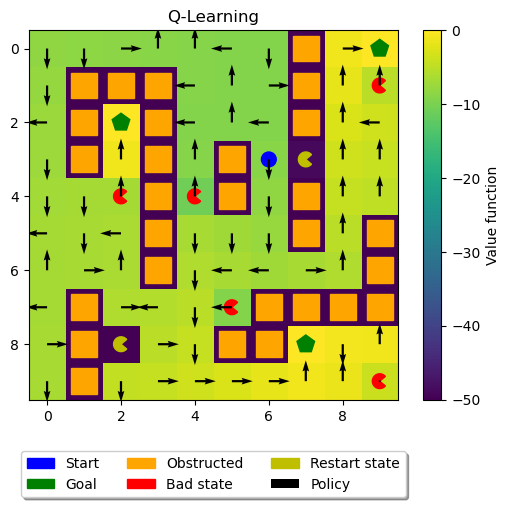

In [20]:

plot_gridworld(env_0, policy=pi,value_function=avg_q, title="Q-Learning")

In [21]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[0,4]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                              bias=0.5)

env_1 = gw.create_gridworld()


In [22]:

def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    epsilon = trial.suggest_float('epsilon', 0.1, 0.5, log=True)
    g=trial.suggest_float('gamma',0.8,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Epsilon = {epsilon},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
    gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=1,
                                bias=0.5)

    env_1 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts, steps, rewards = qlearning(env_1, alpha=alpha, epsilon=epsilon, maxiter=100, maxeps=5000)
        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials



[I 2024-02-27 15:02:53,167] A new study created in memory with name: no-name-d0b10c7f-0936-4cb6-ae0d-8b9021d63428


Trial 0: Alpha = 0.29293437540951867, Epsilon = 0.11611565554872545,Gamma=0.917706328986035
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:03:09,776] Trial 0 finished with value: 84985.7 and parameters: {'alpha': 0.29293437540951867, 'epsilon': 0.11611565554872545, 'gamma': 0.917706328986035}. Best is trial 0 with value: 84985.7.


Trial 1: Alpha = 0.14488124310935271, Epsilon = 0.19064604737876015,Gamma=0.8834096059346028
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:03:28,227] Trial 1 finished with value: 109234.4 and parameters: {'alpha': 0.14488124310935271, 'epsilon': 0.19064604737876015, 'gamma': 0.8834096059346028}. Best is trial 0 with value: 84985.7.


Trial 2: Alpha = 0.3712287995047748, Epsilon = 0.12109637473203015,Gamma=0.8563805481916623
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 15:03:44,803] Trial 2 finished with value: 85479.9 and parameters: {'alpha': 0.3712287995047748, 'epsilon': 0.12109637473203015, 'gamma': 0.8563805481916623}. Best is trial 0 with value: 84985.7.


Running episode 4000.
Trial 3: Alpha = 0.45485072570644763, Epsilon = 0.39911120677619716,Gamma=0.9211490126787141
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:04:08,343] Trial 3 finished with value: 174646.9 and parameters: {'alpha': 0.45485072570644763, 'epsilon': 0.39911120677619716, 'gamma': 0.9211490126787141}. Best is trial 0 with value: 84985.7.


Trial 4: Alpha = 0.11316783851574506, Epsilon = 0.16107461883896512,Gamma=0.828074651784896
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:04:26,536] Trial 4 finished with value: 104392.9 and parameters: {'alpha': 0.11316783851574506, 'epsilon': 0.16107461883896512, 'gamma': 0.828074651784896}. Best is trial 0 with value: 84985.7.


Trial 5: Alpha = 0.4533459527796373, Epsilon = 0.25145029831850085,Gamma=0.9201916971734313
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:04:45,788] Trial 5 finished with value: 118489.4 and parameters: {'alpha': 0.4533459527796373, 'epsilon': 0.25145029831850085, 'gamma': 0.9201916971734313}. Best is trial 0 with value: 84985.7.


Trial 6: Alpha = 0.23143680896616045, Epsilon = 0.11503242951155097,Gamma=0.8516739874615249
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:05:02,537] Trial 6 finished with value: 87180.5 and parameters: {'alpha': 0.23143680896616045, 'epsilon': 0.11503242951155097, 'gamma': 0.8516739874615249}. Best is trial 0 with value: 84985.7.


Trial 7: Alpha = 0.21408585045485104, Epsilon = 0.17115366952155192,Gamma=0.9321635273692338
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 15:05:20,447] Trial 7 finished with value: 100373.0 and parameters: {'alpha': 0.21408585045485104, 'epsilon': 0.17115366952155192, 'gamma': 0.9321635273692338}. Best is trial 0 with value: 84985.7.


Running episode 4000.
Trial 8: Alpha = 0.4291006775189408, Epsilon = 0.3109474956468942,Gamma=0.8842453029917271
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:05:41,129] Trial 8 finished with value: 138743.7 and parameters: {'alpha': 0.4291006775189408, 'epsilon': 0.3109474956468942, 'gamma': 0.8842453029917271}. Best is trial 0 with value: 84985.7.


Trial 9: Alpha = 0.1216698285691447, Epsilon = 0.3718852466589901,Gamma=0.9771588312197836
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:06:04,395] Trial 9 finished with value: 174084.1 and parameters: {'alpha': 0.1216698285691447, 'epsilon': 0.3718852466589901, 'gamma': 0.9771588312197836}. Best is trial 0 with value: 84985.7.


Trial 10: Alpha = 0.28724591183359177, Epsilon = 0.11055370814916941,Gamma=0.9841866706363125
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:06:20,938] Trial 10 finished with value: 84871.6 and parameters: {'alpha': 0.28724591183359177, 'epsilon': 0.11055370814916941, 'gamma': 0.9841866706363125}. Best is trial 10 with value: 84871.6.


Trial 11: Alpha = 0.28966390147659304, Epsilon = 0.10725599580321736,Gamma=0.9920733440939509
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 15:06:37,531] Trial 11 finished with value: 84254.6 and parameters: {'alpha': 0.28966390147659304, 'epsilon': 0.10725599580321736, 'gamma': 0.9920733440939509}. Best is trial 11 with value: 84254.6.


Running episode 4000.
Trial 12: Alpha = 0.28143907904757365, Epsilon = 0.10299161502639273,Gamma=0.9951893360284441
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:06:54,141] Trial 12 finished with value: 82904.8 and parameters: {'alpha': 0.28143907904757365, 'epsilon': 0.10299161502639273, 'gamma': 0.9951893360284441}. Best is trial 12 with value: 82904.8.


Trial 13: Alpha = 0.19573915602742414, Epsilon = 0.14404776998523128,Gamma=0.9607439207303813
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:07:11,375] Trial 13 finished with value: 94005.9 and parameters: {'alpha': 0.19573915602742414, 'epsilon': 0.14404776998523128, 'gamma': 0.9607439207303813}. Best is trial 12 with value: 82904.8.


Trial 14: Alpha = 0.3136708663986242, Epsilon = 0.10210400934243355,Gamma=0.9988611158936864
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:07:27,894] Trial 14 finished with value: 82229.9 and parameters: {'alpha': 0.3136708663986242, 'epsilon': 0.10210400934243355, 'gamma': 0.9988611158936864}. Best is trial 14 with value: 82229.9.


Trial 15: Alpha = 0.3537863042659228, Epsilon = 0.22966523703818395,Gamma=0.9560713529464141
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:07:46,877] Trial 15 finished with value: 112089.7 and parameters: {'alpha': 0.3537863042659228, 'epsilon': 0.22966523703818395, 'gamma': 0.9560713529464141}. Best is trial 14 with value: 82229.9.


Trial 16: Alpha = 0.17547502399067635, Epsilon = 0.49102981046593874,Gamma=0.8021067971682436
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:08:15,242] Trial 16 finished with value: 238396.4 and parameters: {'alpha': 0.17547502399067635, 'epsilon': 0.49102981046593874, 'gamma': 0.8021067971682436}. Best is trial 14 with value: 82229.9.


Trial 17: Alpha = 0.2517678787473737, Epsilon = 0.1390646933235927,Gamma=0.99786864115794
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:08:32,391] Trial 17 finished with value: 91884.7 and parameters: {'alpha': 0.2517678787473737, 'epsilon': 0.1390646933235927, 'gamma': 0.99786864115794}. Best is trial 14 with value: 82229.9.


Trial 18: Alpha = 0.34029195929003964, Epsilon = 0.10068180872579571,Gamma=0.9500358176583596
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 15:08:48,814] Trial 18 finished with value: 81457.7 and parameters: {'alpha': 0.34029195929003964, 'epsilon': 0.10068180872579571, 'gamma': 0.9500358176583596}. Best is trial 18 with value: 81457.7.


Running episode 4000.
Trial 19: Alpha = 0.3624605224732844, Epsilon = 0.19607753918097914,Gamma=0.9463948942403204
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 15:09:06,874] Trial 19 finished with value: 103497.6 and parameters: {'alpha': 0.3624605224732844, 'epsilon': 0.19607753918097914, 'gamma': 0.9463948942403204}. Best is trial 18 with value: 81457.7.


Running episode 4000.


In [23]:


# Get the best hyperparameters


best_alpha = study.best_params['alpha']
best_epsilon = study.best_params['epsilon']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best Epsilon:", best_epsilon)
print("Best gamma:", best_gamma)




Best Hyperparameters:
Best Alpha: 0.34029195929003964
Best Epsilon: 0.10068180872579571
Best gamma: 0.9500358176583596


In [24]:


num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                                bias=0.5)

env_1 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = qlearning(env_1, alpha=best_alpha, epsilon=best_epsilon, maxiter=100, maxeps=5000)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)


Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [25]:

avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


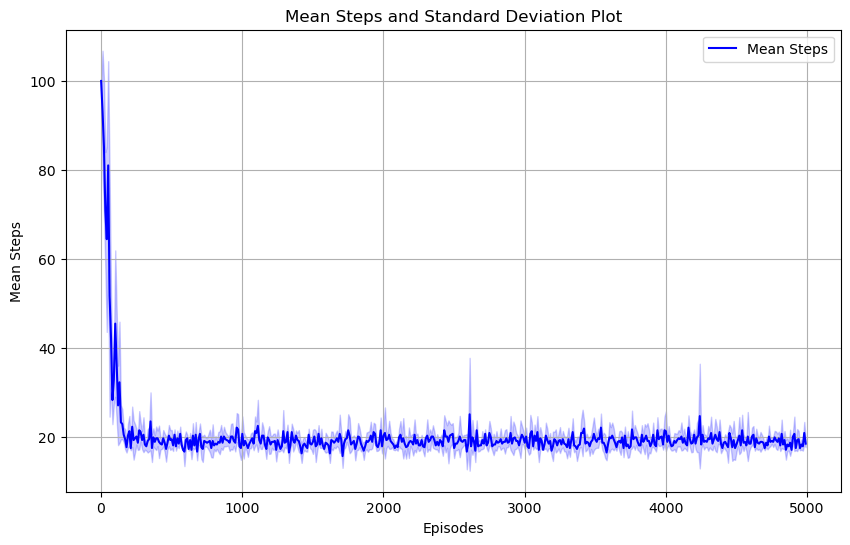

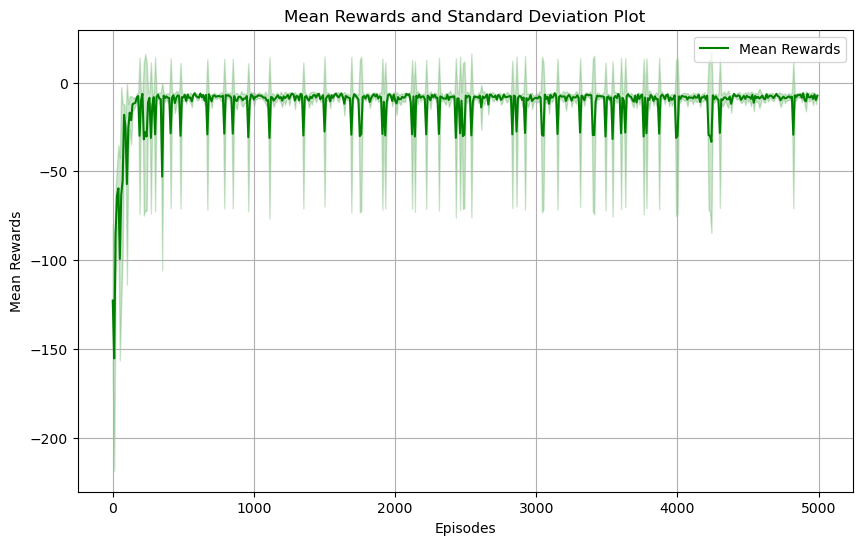

In [26]:


import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


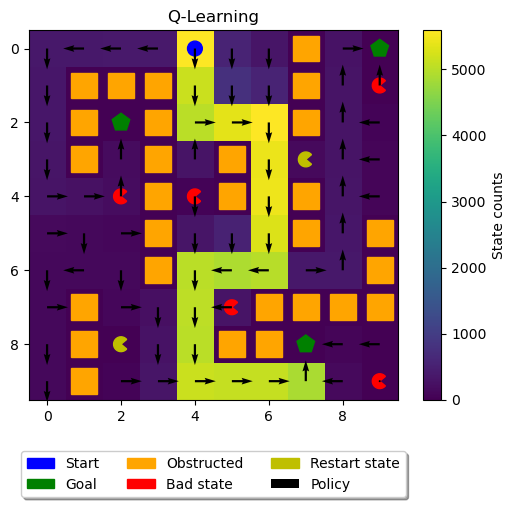

In [27]:


plot_gridworld(env_1, policy=pi, state_counts=avg_state, title="Q-Learning")


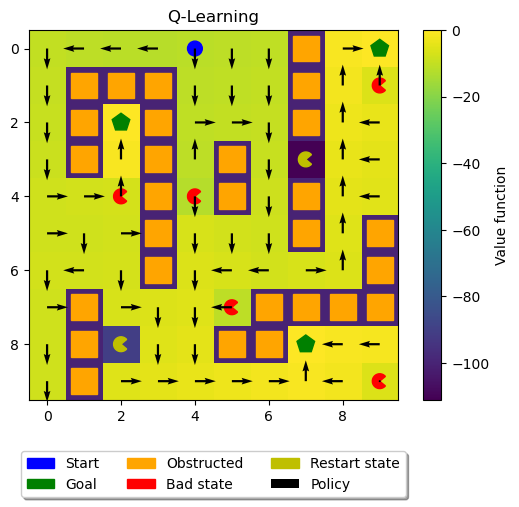

In [28]:


plot_gridworld(env_1, policy=pi,value_function=avg_q, title="Q-Learning")


In [29]:

def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    temp = trial.suggest_float('temperature',0.1,1, log=True)
    g=trial.suggest_float('gamma',0.8,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Temperature = {temp},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=g)
    gw.add_obstructions(obstructed_states=obstructions,
                            bad_states=bad_states,
                            restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                    goal_reward=10,
                    bad_state_reward=-6,
                    restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=1,
                                    bias=0.5)

    env_1 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts,steps,rewards = qlearning(env_1, alpha=alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=temp)

        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials


[I 2024-02-27 15:09:24,134] A new study created in memory with name: no-name-42ee45b1-3c13-4f32-8f90-25409861ee15


Trial 0: Alpha = 0.16488912103635442, Temperature = 0.20542673313406826,Gamma=0.9579639514420013
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:09:54,899] Trial 0 finished with value: 76859.1 and parameters: {'alpha': 0.16488912103635442, 'temperature': 0.20542673313406826, 'gamma': 0.9579639514420013}. Best is trial 0 with value: 76859.1.


Trial 1: Alpha = 0.22369590452413582, Temperature = 0.10195025223417371,Gamma=0.8966817829321834
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:10:26,177] Trial 1 finished with value: 75130.4 and parameters: {'alpha': 0.22369590452413582, 'temperature': 0.10195025223417371, 'gamma': 0.8966817829321834}. Best is trial 1 with value: 75130.4.


Trial 2: Alpha = 0.2642638474904512, Temperature = 0.3301949998566589,Gamma=0.9109645840557025
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:11:08,926] Trial 2 finished with value: 121603.4 and parameters: {'alpha': 0.2642638474904512, 'temperature': 0.3301949998566589, 'gamma': 0.9109645840557025}. Best is trial 1 with value: 75130.4.


Trial 3: Alpha = 0.1450669172074643, Temperature = 0.23462968113493274,Gamma=0.8369782720205124
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:12:20,033] Trial 3 finished with value: 238702.3 and parameters: {'alpha': 0.1450669172074643, 'temperature': 0.23462968113493274, 'gamma': 0.8369782720205124}. Best is trial 1 with value: 75130.4.


Trial 4: Alpha = 0.10444440876340574, Temperature = 0.7828929373921144,Gamma=0.8252165519500274
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:14:18,253] Trial 4 finished with value: 444489.1 and parameters: {'alpha': 0.10444440876340574, 'temperature': 0.7828929373921144, 'gamma': 0.8252165519500274}. Best is trial 1 with value: 75130.4.


Trial 5: Alpha = 0.1277729463299037, Temperature = 0.13285186859648837,Gamma=0.9771331994983803
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:14:48,078] Trial 5 finished with value: 75631.9 and parameters: {'alpha': 0.1277729463299037, 'temperature': 0.13285186859648837, 'gamma': 0.9771331994983803}. Best is trial 1 with value: 75130.4.


Trial 6: Alpha = 0.13849780837456388, Temperature = 0.1894041894380415,Gamma=0.8120986439630123
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:16:08,711] Trial 6 finished with value: 268791.1 and parameters: {'alpha': 0.13849780837456388, 'temperature': 0.1894041894380415, 'gamma': 0.8120986439630123}. Best is trial 1 with value: 75130.4.


Trial 7: Alpha = 0.15425721451495858, Temperature = 0.31142303405224103,Gamma=0.8032603846455929
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:17:53,026] Trial 7 finished with value: 373194.4 and parameters: {'alpha': 0.15425721451495858, 'temperature': 0.31142303405224103, 'gamma': 0.8032603846455929}. Best is trial 1 with value: 75130.4.


Trial 8: Alpha = 0.18759215946093133, Temperature = 0.21774955427688988,Gamma=0.9959942334501362
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:18:19,570] Trial 8 finished with value: 68846.8 and parameters: {'alpha': 0.18759215946093133, 'temperature': 0.21774955427688988, 'gamma': 0.9959942334501362}. Best is trial 8 with value: 68846.8.


Trial 9: Alpha = 0.36848478023422615, Temperature = 0.8705595399378808,Gamma=0.8361432856008114
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:20:18,470] Trial 9 finished with value: 438218.30000000005 and parameters: {'alpha': 0.36848478023422615, 'temperature': 0.8705595399378808, 'gamma': 0.8361432856008114}. Best is trial 8 with value: 68846.8.


Trial 10: Alpha = 0.4245009137027477, Temperature = 0.5648921458569363,Gamma=0.9969338696985214
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:20:49,236] Trial 10 finished with value: 82666.1 and parameters: {'alpha': 0.4245009137027477, 'temperature': 0.5648921458569363, 'gamma': 0.9969338696985214}. Best is trial 8 with value: 68846.8.


Trial 11: Alpha = 0.23910009861380455, Temperature = 0.12664477921356015,Gamma=0.8897235887958986
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:21:21,893] Trial 11 finished with value: 82034.8 and parameters: {'alpha': 0.23910009861380455, 'temperature': 0.12664477921356015, 'gamma': 0.8897235887958986}. Best is trial 8 with value: 68846.8.


Trial 12: Alpha = 0.20470603376280225, Temperature = 0.10128278093629346,Gamma=0.9262249169496437
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:21:51,419] Trial 12 finished with value: 71347.20000000001 and parameters: {'alpha': 0.20470603376280225, 'temperature': 0.10128278093629346, 'gamma': 0.9262249169496437}. Best is trial 8 with value: 68846.8.


Trial 13: Alpha = 0.3088535308316707, Temperature = 0.38808217111136856,Gamma=0.9361318759021033
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:22:30,919] Trial 13 finished with value: 105298.29999999999 and parameters: {'alpha': 0.3088535308316707, 'temperature': 0.38808217111136856, 'gamma': 0.9361318759021033}. Best is trial 8 with value: 68846.8.


Trial 14: Alpha = 0.1997130365203437, Temperature = 0.1566722502367848,Gamma=0.8687542591829026
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:23:11,785] Trial 14 finished with value: 111776.5 and parameters: {'alpha': 0.1997130365203437, 'temperature': 0.1566722502367848, 'gamma': 0.8687542591829026}. Best is trial 8 with value: 68846.8.


Trial 15: Alpha = 0.1826960810365423, Temperature = 0.10187155242440102,Gamma=0.9344569556646652
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:23:41,797] Trial 15 finished with value: 72058.6 and parameters: {'alpha': 0.1826960810365423, 'temperature': 0.10187155242440102, 'gamma': 0.9344569556646652}. Best is trial 8 with value: 68846.8.


Trial 16: Alpha = 0.30521165095079344, Temperature = 0.2583875341482841,Gamma=0.9955576738235168
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:24:08,549] Trial 16 finished with value: 65126.2 and parameters: {'alpha': 0.30521165095079344, 'temperature': 0.2583875341482841, 'gamma': 0.9955576738235168}. Best is trial 16 with value: 65126.2.


Trial 17: Alpha = 0.2902377516356263, Temperature = 0.27308588566041336,Gamma=0.9951864947988583
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:24:35,600] Trial 17 finished with value: 66219.9 and parameters: {'alpha': 0.2902377516356263, 'temperature': 0.27308588566041336, 'gamma': 0.9951864947988583}. Best is trial 16 with value: 65126.2.


Trial 18: Alpha = 0.49703079372650305, Temperature = 0.46152067083074594,Gamma=0.9558353660270662
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:25:12,929] Trial 18 finished with value: 97776.20000000001 and parameters: {'alpha': 0.49703079372650305, 'temperature': 0.46152067083074594, 'gamma': 0.9558353660270662}. Best is trial 16 with value: 65126.2.


Trial 19: Alpha = 0.3080457061800977, Temperature = 0.26595621656440477,Gamma=0.9689236401737027
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 15:25:42,997] Trial 19 finished with value: 71407.2 and parameters: {'alpha': 0.3080457061800977, 'temperature': 0.26595621656440477, 'gamma': 0.9689236401737027}. Best is trial 16 with value: 65126.2.


In [30]:


# Get the best hyperparameters


best_alpha = study.best_params['alpha']
best_temp = study.best_params['temperature']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best temp:", best_temp)
print("Best gamma:", best_gamma)



Best Hyperparameters:
Best Alpha: 0.30521165095079344
Best temp: 0.2583875341482841
Best gamma: 0.9955576738235168


In [31]:


num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                                bias=0.5)

env_1 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = qlearning(env_1, alpha=best_alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=best_temp)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)


Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [32]:

avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


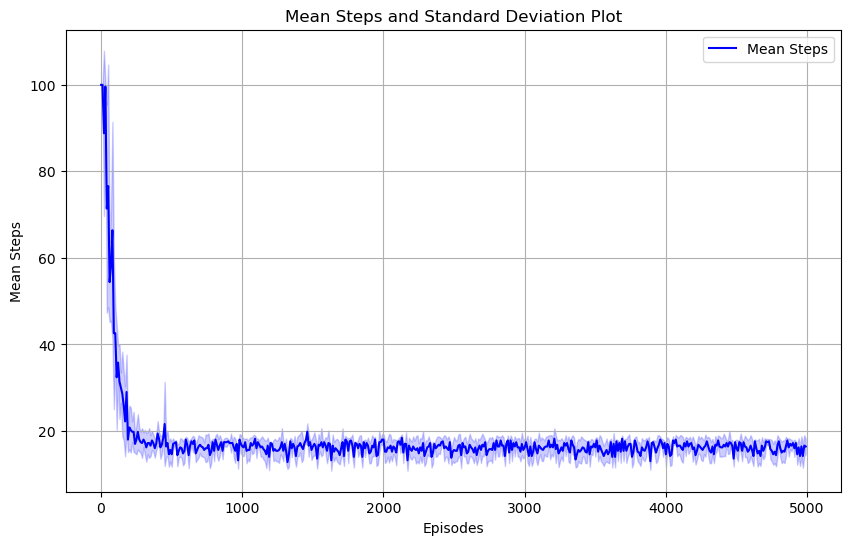

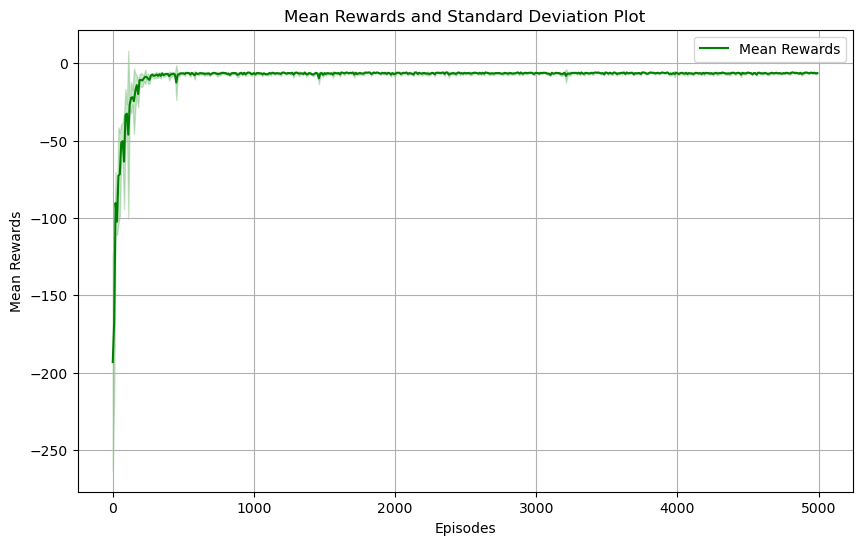

In [33]:


import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


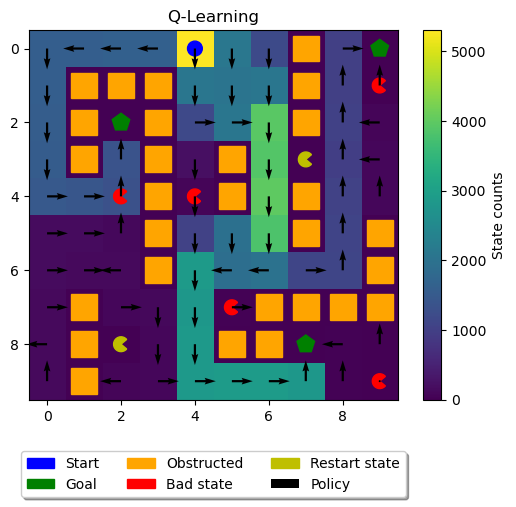

In [34]:



plot_gridworld(env_1, policy=pi, state_counts=avg_state, title="Q-Learning")


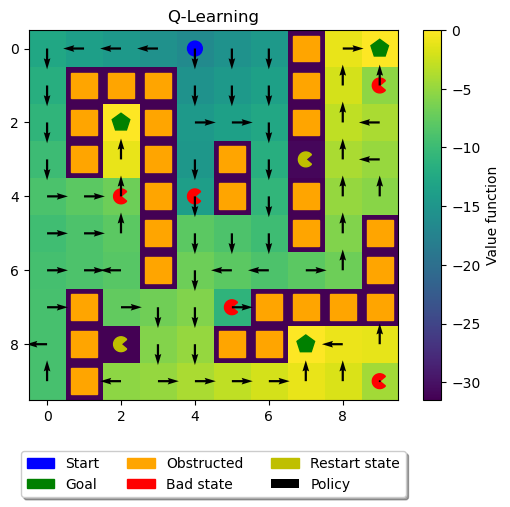

In [35]:


plot_gridworld(env_1, policy=pi,value_function=avg_q, title="Q-Learning")